file path:
Files/mr/
--> 100-192

In [ ]:
pip install pydicom



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.2 MB/s eta 0:00:00


Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 202
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.98571749529828182502109393377503590139
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'MPR']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.9857174952982818250210939337750

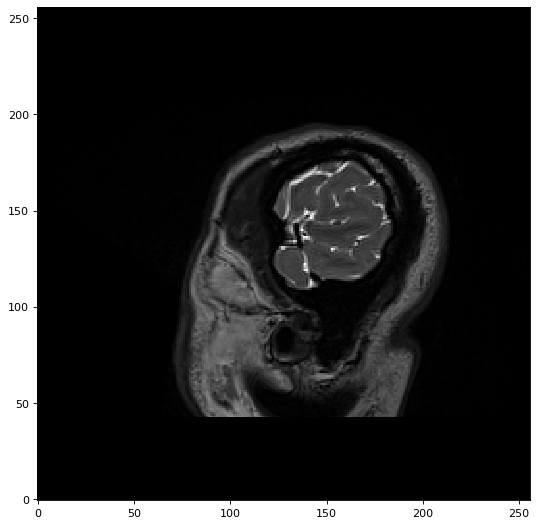

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom

RefDs = pydicom.dcmread('Files/mri/1-033.dcm')
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
# Finally we had already read the file and we have the image information in the pixel_array (final field)
ArrayDicom[:,:]=RefDs.pixel_array
# Some rendering tools here to set the size of that image to a specific value dpi and equal axis or square image as well
# as work with grayscale
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='b')
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale
# Colormesh will require a horizontal and vertical axes
Rows=np.arange(RefDs.Rows)
Columns=np.arange(RefDs.Columns)
# This is the actual rendering
plt.pcolormesh(Rows, Columns, np.flipud(ArrayDicom[:, :]))

# And we will inspect the metadata here
print(RefDs)

Text(0.5, 1.0, 'Segmented Mask')

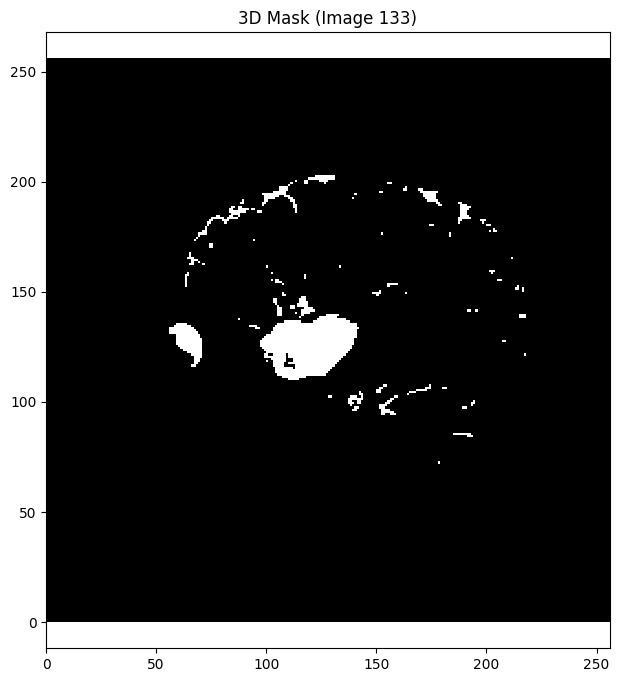

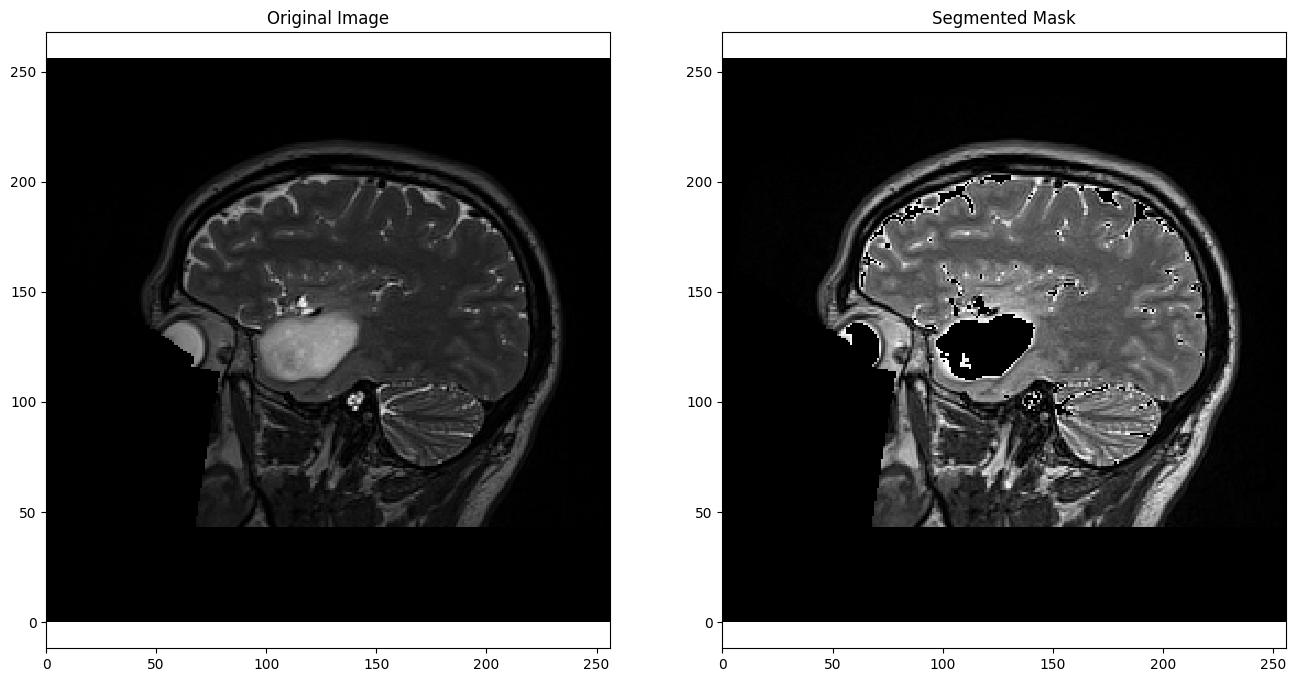

In [ ]:
InFile=100
FinalFile=192
IndexBottom=400


import cv2
import matplotlib.pyplot as plt


fname='Files/mr/1-{:d}.dcm'.format(192)
RefDs = pydicom.dcmread(fname)
ArrayDicom3D = np.zeros((FinalFile-InFile+1,RefDs.Rows,RefDs.Columns), dtype=RefDs.pixel_array.dtype)
SegmentedArrayDicom3D = np.zeros((FinalFile-InFile+1,RefDs.Rows,RefDs.Columns), dtype=RefDs.pixel_array.dtype)

for ix in range(InFile,FinalFile+1):
    # Get file
    fname='Files/mr/1-{:d}.dcm'.format(ix)
    RefDs = pydicom.dcmread(fname)
    # image information is in the pixel_array (final field)
    ArrayDicom3D[ix-InFile,:,:]=RefDs.pixel_array


Threshold = 600

mask3D = np.zeros_like(ArrayDicom3D,'uint8')
#mask3D[ArrayDicom3D <= Threshold] = 0
#mask3D[ArrayDicom3D > Threshold] = 1
mask3D[ArrayDicom3D > Threshold] = 255  # white
mask3D[ArrayDicom3D <= Threshold] = 0
mask3D[:,IndexBottom:512,0:512] = 0   #removes the bottom of the image

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(np.flipud(mask3D[33]))
plt.title('3D Mask (Image 133)')
plt.axis('equal') # makes the image square

TotImages=len(ArrayDicom3D[:,1,1])


for ix in range(0,TotImages):
    ret, markers = cv2.connectedComponents(mask3D[ix])  # detects all the regions within the mask
    #plt.imshow(mask3D[ix])    #uncomment this to see all the masks
    #plt.show()

    # histogram to determine which of the regions has the highest number of pixels
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
    # the highest number of pixels are evidently on the black (background), so we look for the second highest
    inxhist=np.argsort(hist)  #indexes of the sorted histogram
    inxbone=inxhist[-1]
    ROI=np.zeros_like(ArrayDicom3D[ix],'uint8')
    ROI[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region
    SegmentedArrayDicom3D[ix,:,:]=ROI*ArrayDicom3D[ix,:,:]


VisImage=33

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(np.flipud(ArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(122)
plt.pcolormesh(np.flipud(SegmentedArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')

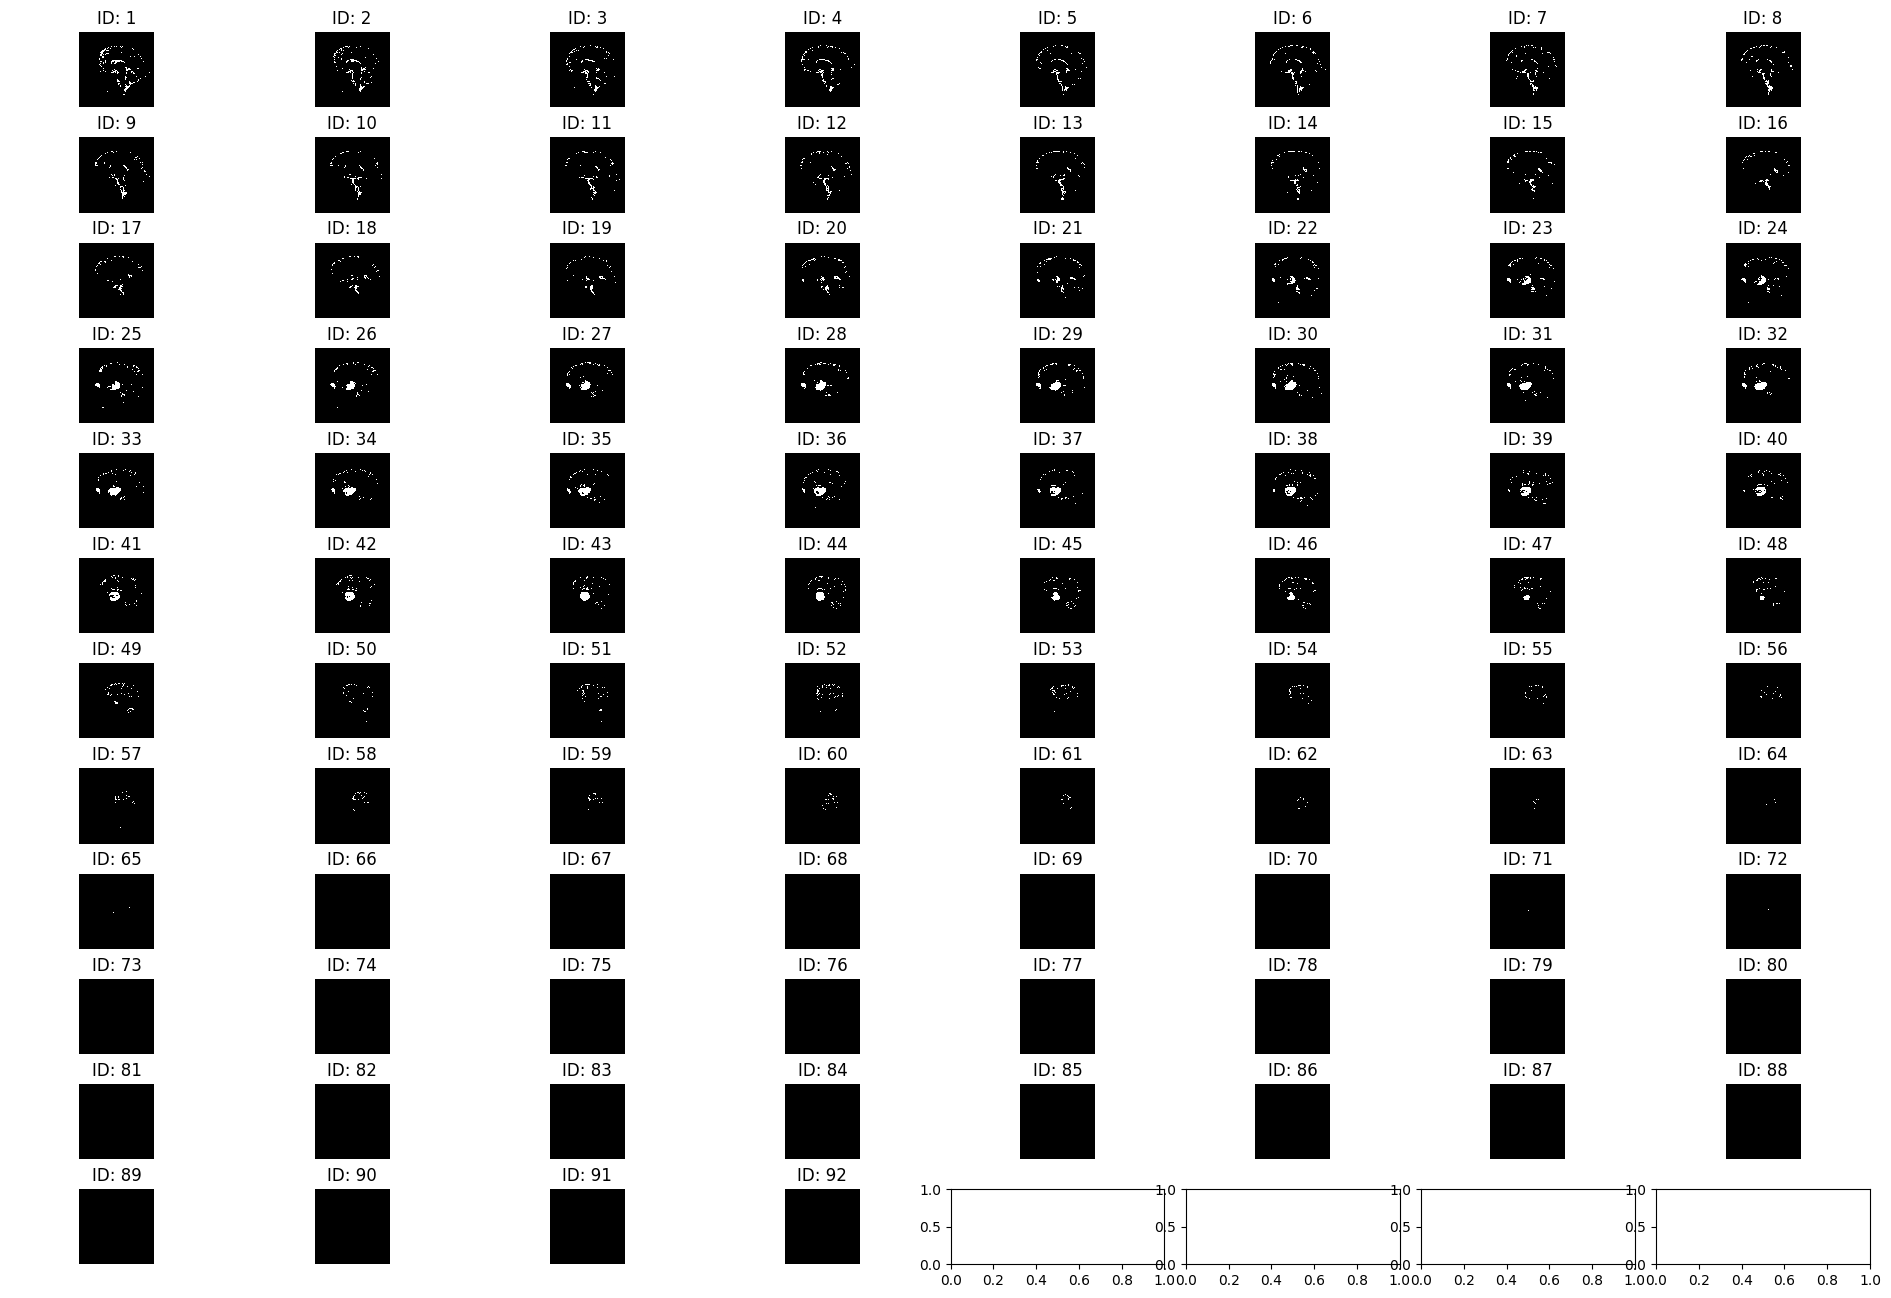

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#display each image with the 3d mask
fig, axes = plt.subplots(nrows=12, ncols=8, figsize=(24, 16))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop through and plot each image
for i in range(0, 92):
    ax = axes[i]
    ax.pcolormesh(np.flipud(mask3D[i]), cmap='gray')
    ax.set_title(f"ID: {i+1}")  # Title with img ID number
    ax.axis('equal')  # Make the image square
    ax.axis('off')  # Turn off axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()


Text(0.5, 1.0, 'Segmented Mask Regions out of 69 regions detected')

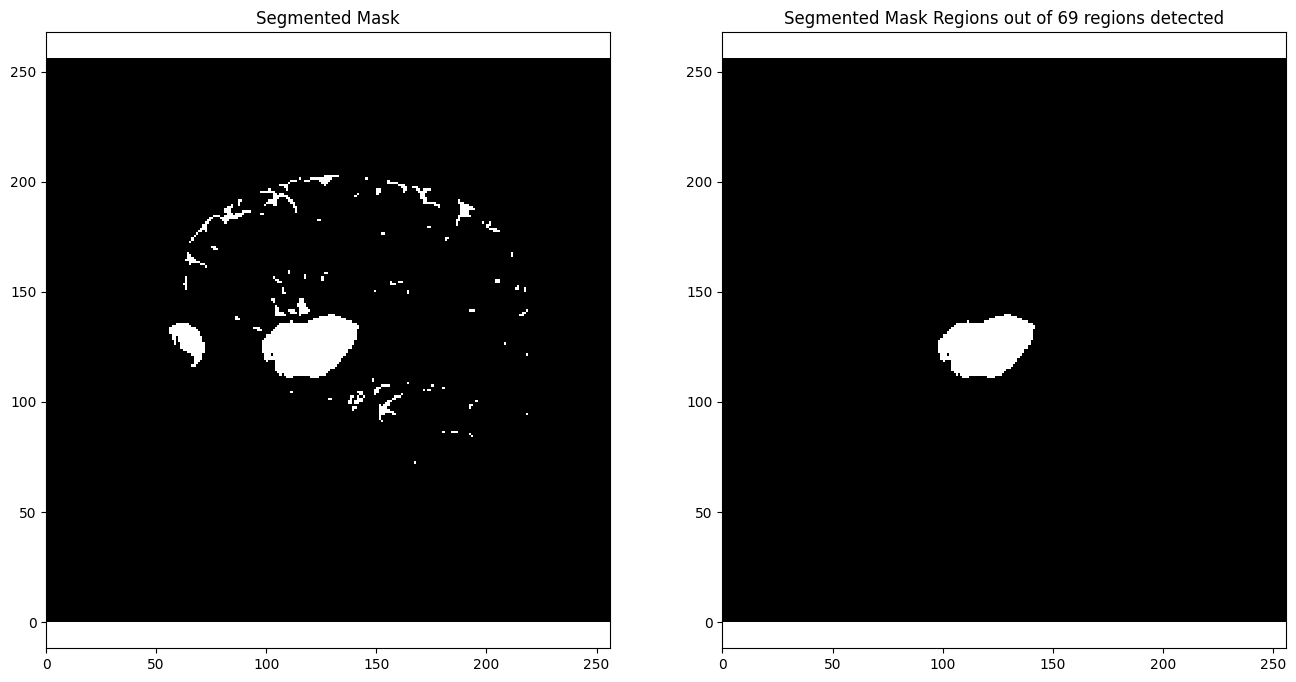

In [ ]:
import cv2

plt.figure(figsize=(16, 8))
ret, markers = cv2.connectedComponents(mask3D[32])  # detect all the regions within the mask

hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
inxhist=np.argsort(hist)  #indexes of the sorted histogram
inxbone=inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
ROI=np.zeros_like(ArrayDicom,'uint8')
ROI[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region

plt.subplot(121)
plt.pcolormesh(np.flipud(mask3D[32]))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask')
plt.subplot(122)
plt.pcolormesh(np.flipud(ROI))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask Regions out of '+str(ret)+' regions detected')

Text(0.5, 1.0, 'Original Image Sobel filtered - High Pass')

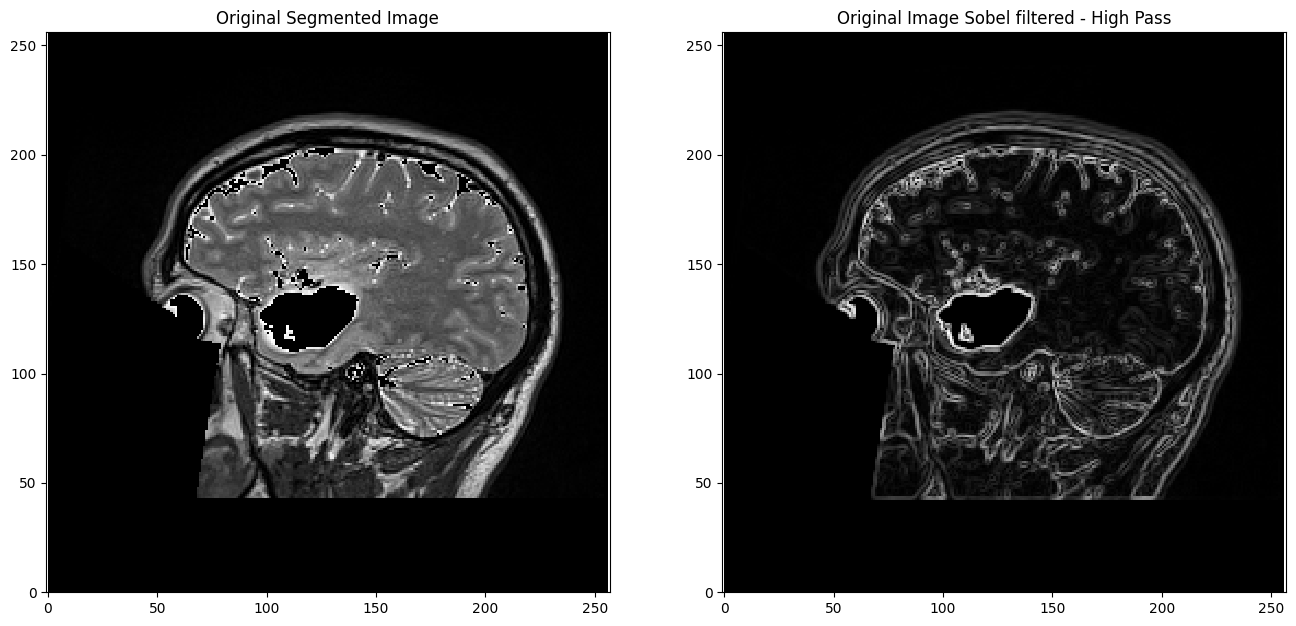

In [ ]:
from scipy import ndimage

ImageSobelFx=ndimage.sobel(SegmentedArrayDicom3D[VisImage],axis=0, mode='constant')
ImageSobelFy=ndimage.sobel(SegmentedArrayDicom3D[VisImage],axis=1, mode='constant')
ImageSobelF=np.hypot(ImageSobelFx, ImageSobelFy)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.pcolormesh(np.flipud(SegmentedArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Original Segmented Image')
plt.subplot(222)
plt.pcolormesh(np.flipud(ImageSobelF))
plt.axis('equal') #this makes the image square
plt.title('Original Image Sobel filtered - High Pass')

Text(0.5, 1.0, 'Original Image Sobel filtered - High Pass')

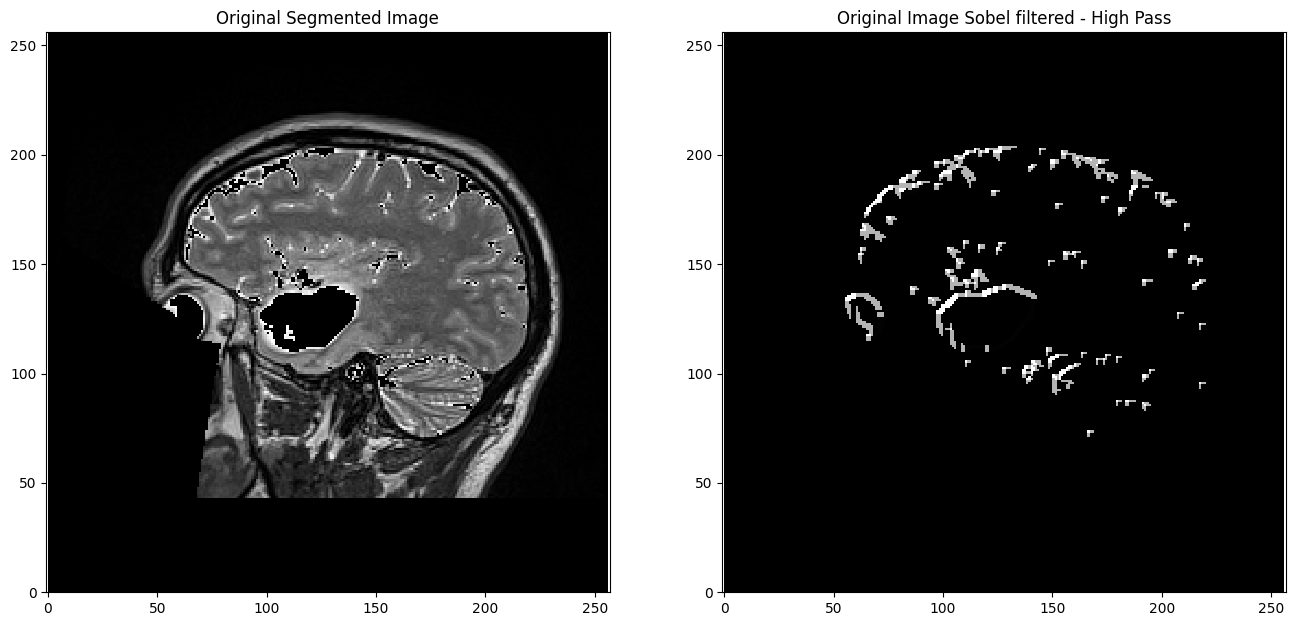

In [ ]:
from scipy import ndimage

ImageSobelFx=ndimage.sobel(mask3D[32],axis=0, mode='constant')
ImageSobelFy=ndimage.sobel(mask3D[32],axis=1, mode='constant')
ImageSobelF=np.hypot(ImageSobelFx, ImageSobelFy)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.pcolormesh(np.flipud(SegmentedArrayDicom3D[VisImage]))
plt.axis('equal') #this makes the image square
plt.title('Original Segmented Image')
plt.subplot(222)
plt.pcolormesh(np.flipud(ImageSobelF))
plt.axis('equal') #this makes the image square
plt.title('Original Image Sobel filtered - High Pass')

In [ ]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact_manual, interact

def make_mesh(image, threshold=5, step_size=1):
    p=image
    # generation of the vertices and faces of polygons using marching cubes
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True)

    return verts, faces

In [ ]:
def plt_3d(verts, faces, orientationX, orientationY):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    x,y,z = zip(*verts)

    # verts[faces] generates a collection of triangles which is needed by Poly3DCollection
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)

    face_color = [0.89, 0.85, 0.79]    #bone colour
    mesh.set_facecolor(face_color)
    mesh.set_edgecolor([0,0,0])    #black
    ax.add_collection3d(mesh)    #creates the volume image

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))

    ax.view_init(orientationX, orientationY)   #sets the orientation of the view

    plt.show()

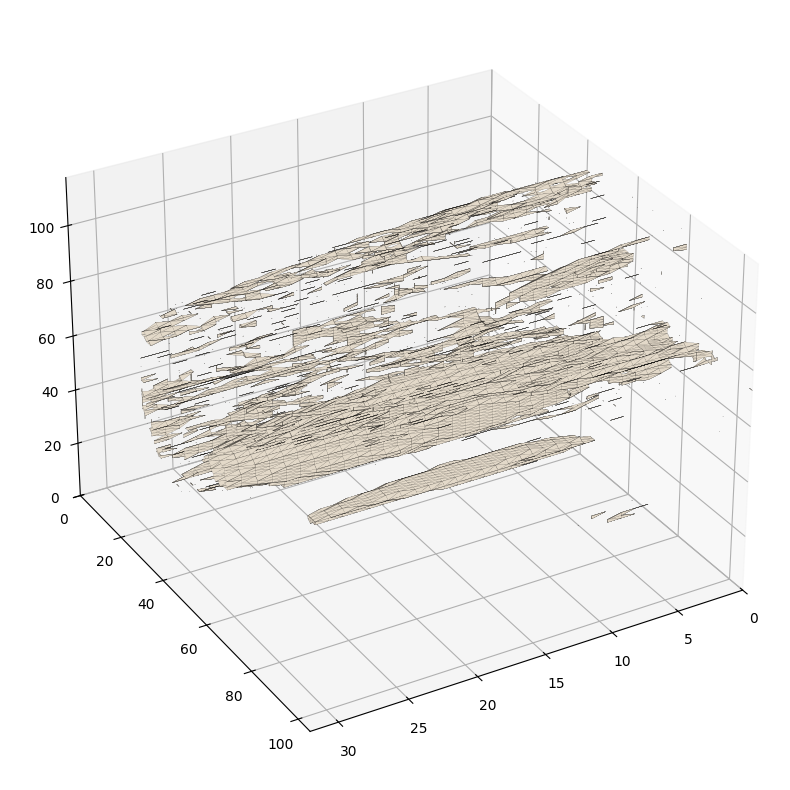

In [ ]:
ImageforVolumeRendering=mask3D[:,::2,::2]

verts, faces = make_mesh(ImageforVolumeRendering, 250)   #calls function to create mesh
plt_3d(verts, faces, 30,60);   #calls function to plot and opens a pager with execution information

#114-146